In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

# Reading racecourse position 

# Processing XML in Python — ElementTree
https://towardsdatascience.com/processing-xml-in-python-elementtree-c8992941efd2

In [3]:
# Name of all xml files
filess = ('bermuda_22051401','bermuda_22051402','bermuda_22051403','bermuda_22051504','bermuda_22051505',
          'chicago_22061801','chicago_22061802','chicago_22061803','chicago_22061904','chicago_22061905',
         'plymouth_22073001','plymouth_22073002','plymouth_22073003','plymouth_22073104','plymouth_22073105',
          'plymouth_22073106','cph_22082001','cph_22082002','cph_22082003',
          'cadiz_22092401','cadiz_22092402','cadiz_22092403','cadiz_22092504','cadiz_22092505',
         'dubai_22111201','dubai_22111202','dubai_22111203','dubai_22111304','dubai_22111305','dubai_22111306')

In [4]:
filess_df = pd.DataFrame(filess)

In [5]:
from os.path import exists as file_exists
#Loafing xml files and creating a list of their parse
def load_xml_files(files):
    """ This functions loads the xml files
    from the different locations 
    and 
    Input: date of race and .xml file
    -------------------------------
    Output: dataframe with coordinate 
    positions of course marks 
    """

    list_of_xml = []
   
    for file in files:

        xml_file = "xml_files/{}.xml".format(file)
        if (file_exists(xml_file) == False): #Checking if file excist
            print(xml_file, 'does not excist')
        if file_exists(xml_file): #Checking if file excist
            list_of_xml.append(ET.parse(xml_file))
            

    return(list_of_xml)

In [6]:
list_of_xml_files= load_xml_files(filess)

In [7]:
#Now getting their root          
list_of_roots = []
for i in range(len(list_of_xml_files)):
    list_of_roots.append(list_of_xml_files[i].getroot())

# Generating course mark data

In [8]:
#You can expand the use of the iter() function to help with finding particular elements of interest. 
#root.iter() will list all subelements under the root that match the element specified. 
#Here, you will list all attributes of the mark element in the tree:

courses= []

for i in range(len(list_of_roots)):
    marks = []
    lat = []
    long = []
    place_number = []
    for mark in list_of_roots[i].iter('Mark'):
        m = mark.attrib

        for key,value in m.items():
            if key == 'Name':
                marks.append(value)
            if key == 'TargetLat':
                lat.append(value)
            if key == 'TargetLng':
                long.append(value)
    place_number.append(i)

    #Create a dataframe with the marks and its coordinates
    course = pd.DataFrame(
        {'Marks': marks,
         'Longtitude': long,
         'Latitude': lat ,
         'Destination': i
        })
    course['Longtitude']= course['Longtitude'].astype(float)
    course['Latitude']= course['Latitude'].astype(float)

    course=course.set_index('Marks',)
    
    courses.append(course)
    
#Changing Destination to thecity name to later being able to plot the right data
for i in range(len(courses)):
#     print(i)
    if courses[i]['Destination'][0]==filess_df.index[i]:
        courses[i]['Destination'] =filess_df.iloc[i][0]

        

In [9]:
courses

[       Longtitude   Latitude       Destination
 Marks                                         
 SL1    -64.835851  32.298081  bermuda_22051401
 SL2    -64.837792  32.299509  bermuda_22051401
 M1     -64.833785  32.304300  bermuda_22051401
 LG1    -64.842121  32.307117  bermuda_22051401
 LG2    -64.840505  32.308741  bermuda_22051401
 WG1    -64.832447  32.300200  bermuda_22051401
 WG2    -64.831270  32.301308  bermuda_22051401
 LG1    -64.842121  32.307117  bermuda_22051401
 LG2    -64.840505  32.308741  bermuda_22051401
 WG1    -64.832447  32.300200  bermuda_22051401
 WG2    -64.831270  32.301308  bermuda_22051401
 LG1    -64.842121  32.307117  bermuda_22051401
 LG2    -64.840505  32.308741  bermuda_22051401
 FL1    -64.837405  32.316675  bermuda_22051401
 FL2    -64.835959  32.316151  bermuda_22051401,
        Longtitude   Latitude       Destination
 Marks                                         
 SL1    -64.835851  32.298081  bermuda_22051402
 SL2    -64.837792  32.299509  bermuda_

## Generating course Boundaries data

In [43]:
# Instead of the marks we now look at the boundary points. 
boundaries= []

for i in range(len(list_of_roots)):
    bondaries = []
    lat = []
    long = []
    for bound in list_of_roots[i].iter('Limit'):
        m = bound.attrib

        for key,value in m.items():
            if key == 'SeqID':
                bondaries.append(value)
            if key == 'Lat':
                lat.append(value)
            if key == 'Lon':
                long.append(value)

    #Create a dataframe with the marks and its coordinates
    boundary = pd.DataFrame(
        {'Latitude': lat,
            'Longtitude': long,
         'Destination': i

        })
    boundary['Longtitude']=boundary['Longtitude'].astype(float)
    boundary['Latitude']=boundary['Latitude'].astype(float)
    #The boundary points are the first 11 points.
    boundary.loc[len(boundary[:11])] =boundary.loc[0]
    boundaries.append(boundary[:12])
    
    
#Changing Destination to the city name to later being able to plot the right data
for i in range(len(boundaries)):
    if boundaries[i]['Destination'][0]==filess_df.index[i]:
        boundaries[i]['Destination'] =filess_df.iloc[i][0]

        

C:\Users\katja\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Now plotting the couse 

In [44]:
#Following packages are needed
import folium
from folium.features import DivIcon
%matplotlib inline
import pandas as pd
import re
import os
import branca.colormap as cm
import re


# Plotting the one course I want to look at 

In [85]:
#Having a map of the whole world
map_world = folium.Map([36.52978, -6.29465], zoom_start=1)

#Course to look at:
#Choose one of following: 

# ('bermuda_22051401','bermuda_22051402','bermuda_22051403','bermuda_22051504','bermuda_22051505',
#           'chicago_22061801','chicago_22061802','chicago_22061803','chicago_22061904','chicago_22061905',
#          'plymouth_22073001','plymouth_22073002','plymouth_22073003','plymouth_22073104','plymouth_22073105',
#           'plymouth_22073106','cph_22082001','cph_22082002','cph_22082003','cadiz_22092401',
#          'cadiz_22092402','cadiz_22092403','cadiz_22092504','cadiz_22092505')

course_to_look_at = 'cph_22082001'


#Defining the colors of the marks: yellow is starting line, red is the course and blue is finish. 
colors = {'SL1' : 'green', 'SL2' : 'green','M1':'red','LG1' : 'red','LG2' : 'red','WG1' : 'red','WG2' : 'red','FL1' : 'blue','FL2' : 'blue'}

for i in range(len(courses)):
    if courses[i]['Destination'][0] == course_to_look_at:
        for _, row in courses[i].iterrows():
            folium.CircleMarker(location=[row["Latitude"], row["Longtitude"]], 
                                        radius=5, fill_color=colors[_]).add_to(map_world)

            folium.Marker(location=[row["Latitude"], row["Longtitude"]], icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0),
                html='<div style="font-size: 16pt; color : {}">{}</div>'.format(colors[_], 
                                                                                _))).add_to(map_world)





# Plotting marks and boundaries

In [86]:
#Define the course to look at: 
course_to_look_at = 'cph_22082001'

boundary_colors = ['grey','darkgrey','silver','lightgrey','snow','grey','darkgrey','silver','lightgrey','snow',
          'grey','darkgrey','silver','lightgrey','snow','grey','darkgrey','silver','lightgrey','snow',
          'grey','darkgrey','silver','lightgrey','snow']

for i in range(len(boundaries)):
    if boundaries[i]['Destination'][0] == course_to_look_at:
        boundaries[i].apply(lambda row:folium.CircleMarker(location=[row["Latitude"], 
                                                      row["Longtitude"]],
                                                 radius=2).add_to(map_world),axis=1)

        #Drawing a line between the coordinates
    #     for j in range(len(boundaries)):
        folium.PolyLine((boundaries[i][['Latitude','Longtitude']]),
                        color=boundary_colors[i],
                        line_weight=0.1
                       ).add_to(map_world)


In [87]:
map_world

# Loading races to plot 

In [88]:
df = pd.read_csv('df.csv')

In [89]:
race_number = 22082001

#Now drawing the line that DEN sailed 
den_cadiz_day1_race1=df.loc[df['BOAT']=='DEN'].loc[df['TRK_RACE_NUM_unk']==race_number]#.loc[df['TRK_LEG_NUM_unk']==2]
den_cadiz_day1_race1_toplot = den_cadiz_day1_race1[['Latitude','Longitude']]

nzl_cadiz_day1_race1=df.loc[df['BOAT']=='NZL'].loc[df['TRK_RACE_NUM_unk']==race_number]#.loc[df['TRK_LEG_NUM_unk']==2]
nzl_cadiz_day1_race1_toplot = nzl_cadiz_day1_race1[['Latitude','Longitude']]

fra_cadiz_day1_race1=df.loc[df['BOAT']=='FRA'].loc[df['TRK_RACE_NUM_unk']==race_number].loc[df['TRK_LEG_NUM_unk']==2]
fra_cadiz_day1_race1_toplot=fra_cadiz_day1_race1[['Latitude','Longitude']]

aus_cadiz_day1_race1=df.loc[df['BOAT']=='AUS'].loc[df['TRK_RACE_NUM_unk']==race_number].loc[df['TRK_LEG_NUM_unk']==2]
aus_cadiz_day1_race1_toplot=aus_cadiz_day1_race1[['Latitude','Longitude']]

usa_cadiz_day1_race1=df.loc[df['BOAT']=='USA'].loc[df['TRK_RACE_NUM_unk']==race_number]#.loc[df['TRK_LEG_NUM_unk']==2]
usa_cadiz_day1_race1_toplot=usa_cadiz_day1_race1[['Latitude','Longitude']]



# #Plot DEN as red last
# folium.PolyLine((den_cadiz_day1_race1_toplot),
#                 color='red',
#                 line_weight=0.1
#                ).add_to(map_world)
# Plot NZL as black 1st
folium.PolyLine((usa_cadiz_day1_race1_toplot),
                color='black',
                line_weight=0.1
               ).add_to(map_world)
#Plot FRA as blue 2nd
# folium.PolyLine((fra_cadiz_day1_race1_toplot),
#                 color='blue',
#                 line_weight=0.1
#                ).add_to(map_world)
# #Plot USA as dark blue3nd
# folium.PolyLine((usa_cadiz_day1_race1),
#                 color='purple',
#                 line_weight=0.1
#                ).add_to(map_world)



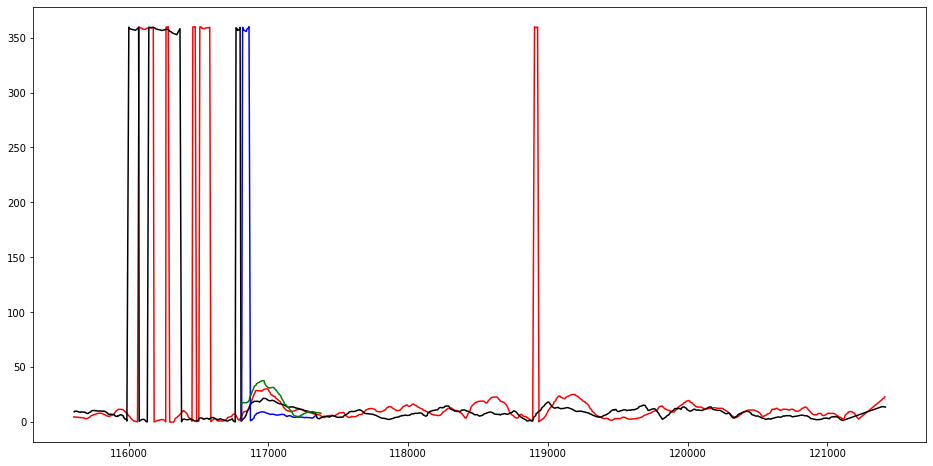

In [90]:
den_cadiz_day1_race1['TWD'].plot(color='r',figsize=(16,8))
nzl_cadiz_day1_race1['TWD'].plot(color='black')
fra_cadiz_day1_race1['TWD'].plot(color='b')
aus_cadiz_day1_race1['TWD'].plot(color='g')

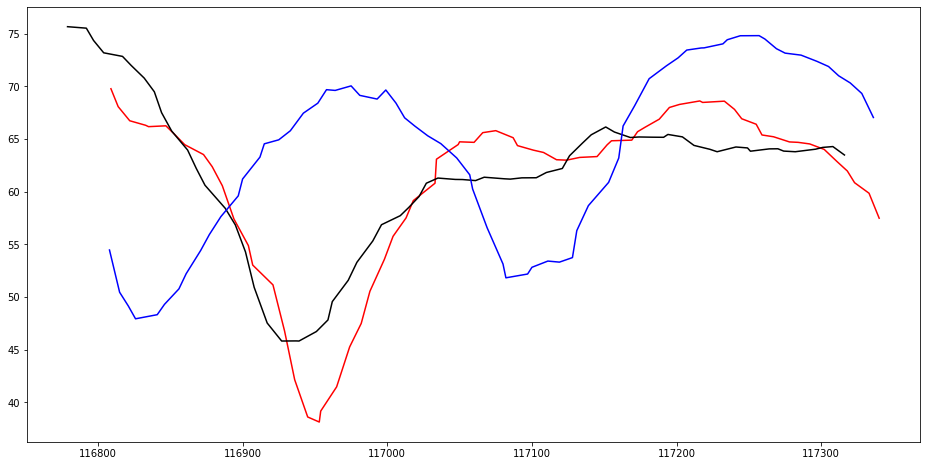

In [91]:
den_cadiz_day1_race1.loc[den_cadiz_day1_race1['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='r',figsize=(16,8))
nzl_cadiz_day1_race1.loc[nzl_cadiz_day1_race1['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='black')
fra_cadiz_day1_race1.loc[fra_cadiz_day1_race1['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='b')
# aus_cadiz_day1_race1.loc[fra_cadiz_day1_race1['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='g')



In [92]:
df.loc[df['TRK_RACE_NUM_unk']==race_number].loc[df['TRK_LEG_NUM_unk']==5]['TWD'].mean()

20.690365205843307

In [93]:
den_cadiz_day1_race1

,BOAT,DATETIME,Latitude,Longitude,BSP_kmh,TWS_kmh,TWD,TWA,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,PC_TTB_s,PC_TTK_s,TTS_s,extra,unk_race_ID,POSITION_AT_LAST_MARK*,DELTA
115607,DEN,2022-08-20 13:34:01,55.713093,12.630572,17.48,26.85,4.67,-38.25,22082001.0,0.0,106.73,98.35,119.3,1.0,2022-08-20 13:34:01,NaN,-3.0
115618,DEN,2022-08-20 13:34:02,55.713124,12.630625,17.31,27.15,4.61,-36.93,22082001.0,0.0,101.45,97.55,118.2,1.0,2022-08-20 13:34:01,NaN,-3.0
115624,DEN,2022-08-20 13:34:03,55.713156,12.630675,16.53,26.45,4.56,-35.68,22082001.0,0.0,100.63,96.30,117.2,1.0,2022-08-20 13:34:01,NaN,-3.0
115634,DEN,2022-08-20 13:34:04,55.713187,12.630722,15.88,26.55,4.47,-33.78,22082001.0,0.0,103.44,95.30,116.3,1.0,2022-08-20 13:34:01,NaN,-3.0
115636,DEN,2022-08-20 13:34:05,55.713218,12.630764,15.18,26.58,4.40,-32.58,22082001.0,0.0,105.23,94.10,115.2,1.0,2022-08-20 13:34:01,NaN,-3.0
115649,DEN,2022-08-20 13:34:06,55.713248,12.630804,14.30,26.48,4.28,-32.26,22082001.0,0.0,107.86,93.10,114.2,1.0,2022-08-20 13:34:01,NaN,-3.0
115651,DEN,2022-08-20 13:34:07,55.713275,12.630840,13.72,26.14,4.13,-31.53,22082001.0,0.0,118.28,91.75,113.3,1.0,2022-08-20 13:34:01,NaN,-3.0
115661,DEN,2022-08-20 13:34:08,55.713302,12.630877,13.07,25.39,4.12,-32.30,22082001.0,0.0,115.84,90.35,112.2,1.0,2022-08-20 13:34:01,NaN,-3.0
115668,DEN,2022-08-20 13:34:09,55.713328,12.630913,13.42,25.43,4.05,-32.79,22082001.0,0.0,117.72,89.35,111.2,1.0,2022-08-20 13:34:01,NaN,-3.0
115677,DEN,2022-08-20 13:34:10,55.713353,12.630949,12.76,25.39,3.80,-33.68,22082001.0,0.0,119.77,88.35,110.3,1.0,2022-08-20 13:34:01,NaN,-3.0


In [94]:
map_world